In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from pandas import get_dummies
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set() # plot styling

<h1>Load data</h1>

In [2]:
file_name = "iris.data.csv"

In [3]:
#load the dataset into memory
dataset = pd.read_csv(file_name,header=None,\
                      names=['sepal_length','sepal_width','petal_length','petal_width','species'])
#check several examples of data
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


<h1>Data preprocessing</h1>

In [4]:
#simple function to process the data.
"""
input:
    data: iris dataset
    num_features: 2 => select only petal width and petal width.
                  4 => select all features
    flower: 'Iris-setosa' => labels of Iris-setosa will be 1 and others will be 0
            'Iris-virginica' => labels of Iris-virginica will be 1 and others will be 0
            'None' => use one-hot encoding to represent the labels

return:
    x: normalized & shuffled data
    y: labels
"""
def data_preprocessing(data,num_features,flower=None):
    if num_features==2:
        features = data.columns[2:4]
    else:
        features = data.columns[0:4]
    labels = dataset.columns[4]
    print(features)
    print(labels)
    #normalize the data
    data_norm = pd.DataFrame(data)
    for feature in features:
        data[feature] = (data[feature]-data[feature].mean())/data[feature].std()

    #shuffle the data
    indices = data_norm.index.tolist()
    indices = np.array(indices)
    np.random.shuffle(indices)
    x = data_norm.reindex(indices)[features]
    y = data_norm.reindex(indices)[labels]
    if flower=='Iris-setosa':
        for i in range(len(y)):
            y[i]=1 if y[i]=='Iris-setosa' else 0
        y = y.values.reshape(len(y),1)
    elif flower=='Iris-virginica':
        for i in range(len(y)):
            y[i]=1 if y[i]=='Iris-virginica' else 0
        y = y.values.reshape(len(y),1)
    else:
        y = get_dummies(y)
    return x,y

<h1>Part a:

In [9]:
x_1,y_1 = data_preprocessing(dataset,2,flower='Iris-setosa')
#generate traning and validation sets
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x_1,y_1,test_size=0.3)

Index(['petal_length', 'petal_width'], dtype='object')
species


In [10]:
x_train_1.head()

,petal_length,petal_width
9,-1.280118,-1.439627
147,0.816888,1.050019
2,-1.393470,-1.308593
79,-0.146601,-0.260321
60,-0.146601,-0.260321


<h2>Define hyper-parameters</h2>

In [11]:
num_epochs = 100
lr = 0.01

<h2>Define Placeholder and Variables</h2>

In [12]:
tf.reset_default_graph()
x_in = tf.placeholder(tf.float32, shape=[None, 2])
y_hat = tf.placeholder(tf.float32, shape=[None, 1])

# perceptron just dot product + b
w = tf.Variable(tf.random_normal(shape=[2,1]), tf.float32)
b = tf.Variable(tf.zeros([1,1]),tf.float32)

<h2>Define update rule and accuracy</h2>

In [13]:
# copied and adapted from class sample code
y = tf.round(tf.sigmoid(tf.add(tf.matmul(x_in, w),b)))
#the error between target and logit
error = y - y_hat

#weight and bias update rule w(t+1) = w(t) + learning_rate * error * x
dW = tf.matmul(tf.transpose(x_in),error)
db = tf.reduce_sum(error,0)
W_ = w + lr*dW
b_ = b + lr*db

#group two operations together
step = tf.group(w.assign(W_), b.assign(b_))

# accuracy measure, will divide later
acc = tf.reduce_sum(tf.cast(tf.equal(y,y_hat), tf.float32))

<h2>Execute training</h2>

In [72]:
#initialize tensorflow variables
init = tf.global_variables_initializer()
py_acc = []

#start tensorflow session
with tf.Session() as sess:
    #run initialization
    sess.run(init)
    #training for number of iterations
    for i in range(num_epochs):
        #every iteration we run optimization on the training data X and labels Y
        sess.run(step,feed_dict = {x_in: x_train_1, y_hat: y_train_1})
        t_acc = sess.run(acc,feed_dict = {x_in: x_train_1, y_hat: y_train_1})
        py_acc.append(t_acc)
        if i % 10 == 0:
            print('Error at given epoch: \t ' + str(t_acc))
        # need to compute the accuracy here
    #after training, we acquire the weight and bias
    #np.squeeze plays a role to get rid of the redundant dimension [i.e.make (2,1) be (2,)]
    py_w = np.squeeze(sess.run(w))
    py_b = np.squeeze(sess.run(b))
    

Error at given epoch: 	 95.0
Error at given epoch: 	 35.0
Error at given epoch: 	 0.0
Error at given epoch: 	 0.0
Error at given epoch: 	 0.0
Error at given epoch: 	 0.0
Error at given epoch: 	 1.0
Error at given epoch: 	 1.0
Error at given epoch: 	 2.0
Error at given epoch: 	 2.0


<h2>Plot</h2>

For decision boundary, we solve:

\begin{equation}
     sigmoid(x \cdot w + b) = 0.5
\end{equation}

Which has solution:

   \begin{equation}
            x_1 = \frac{-1}{w_1} (b + x_2 w_2)
    \end{equation}
So we can plot it as a line.

Test Error is: 	31.11111111111111


(-2, 2)

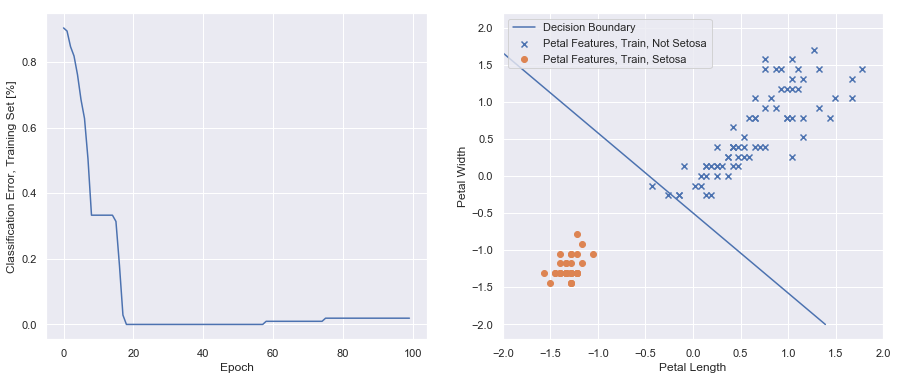

In [73]:
# accuracy curve, in terms of classification error percentage
plt.figure(1, figsize=(15,6))
plt.subplot(121)
plt.plot(np.array(py_acc) / len(y_train_1))
plt.xlabel('Epoch')
plt.ylabel('Classification Error, Training Set [%]')

def sigmoid(x):
    return 1 / (1 + np.exp(-x))
# compute test error
pred = np.round(sigmoid(x_test_1 @ py_w + py_b))
error = np.sum(pred - np.squeeze(y_test_1)) / y_test_1.shape[0]

print('Test Error is: \t' + str(error * 100))

# decision boundary
plt.subplot(122)
x2 = np.linspace(-2, 2, 20) # petal length
x1 = (-1 / py_w[0]) * (py_b + x2 * py_w[1])
plt.plot(x1, x2, label='Decision Boundary')
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
# class 1 indices
idx_1 = np.where(np.squeeze(y_train_1) == 0)[0] # not setosa
idx_2 = np.where(np.squeeze(y_train_1) == 1)[0] # setosa
plt.scatter(x_train_1.petal_length.iloc[idx_1], x_train_1.petal_width.iloc[idx_1], label='Petal Features, Train, Not Setosa', marker='x')
plt.scatter(x_train_1.petal_length.iloc[idx_2], x_train_1.petal_width.iloc[idx_2], label='Petal Features, Train, Setosa', marker='o')
plt.scatter
plt.legend(loc=('upper left'))
plt.xlim(-2,2)

<h1>Part b:</h1>

In [74]:
x_2,y_2 = data_preprocessing(dataset,2,flower='Iris-virginica')
#generate traning and validation sets
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_2,y_2,test_size=0.3)

Index(['petal_length', 'petal_width'], dtype='object')
species


In [75]:
x_train_2.head()

,petal_length,petal_width
15,-1.280118,-1.046525
128,1.043591,1.181053
121,0.646860,1.050019
62,0.136778,-0.260321
14,-1.450146,-1.308593


<h2>Define hyper-parameter</h2>

In [76]:
num_epochs = 100
lr = 0.01

<h2>Define Placeholder and Variables</h2>

In [77]:
tf.reset_default_graph()
# implementing single perceptron, same as before, code copied
x_in = tf.placeholder(tf.float32, shape=[None, 2])
y_hat = tf.placeholder(tf.float32, shape=[None, 1])

# perceptron just dot product + b
w = tf.Variable(tf.random_normal(shape=[2,1]), tf.float32)
b = tf.Variable(tf.zeros([1,1]),tf.float32)


<h2>Define update rule and accuracy</h2>

In [78]:
# same as case 1, still single perceptron
# copied and adapted from class sample code
y = tf.round(tf.sigmoid(tf.add(tf.matmul(x_in, w),b)))
#the error between target and logit
error = y - y_hat

#weight and bias update rule w(t+1) = w(t) + learning_rate * error * x
dW = tf.matmul(tf.transpose(x_in),error)
db = tf.reduce_sum(error,0)
W_ = w + lr*dW
b_ = b + lr*db

#group two operations together
step = tf.group(w.assign(W_), b.assign(b_))

# accuracy measure, will divide later
acc = tf.reduce_sum(tf.cast(tf.equal(y,y_hat), tf.float32))

<h2>Execute training</h2>

In [81]:
# nearly same, feed_dict populated with the new data
#initialize tensorflow variables
init = tf.global_variables_initializer()
py_acc = []

#start tensorflow session
with tf.Session() as sess:
    #run initialization
    sess.run(init)
    #training for number of iterations
    for i in range(num_epochs):
        #every iteration we run optimization on the training data X and labels Y
        sess.run(step,feed_dict = {x_in: x_train_2, y_hat: y_train_2}) # new data
        t_acc = sess.run(acc,feed_dict = {x_in: x_train_2, y_hat: y_train_2})# new data
        py_acc.append(t_acc)
        if i % 10 == 0:
            print('Error at given epoch: \t ' + str(t_acc))
        # need to compute the accuracy here
    #after training, we acquire the weight and bias
    #np.squeeze plays a role to get rid of the redundant dimension [i.e.make (2,1) be (2,)]
    py_w = np.squeeze(sess.run(w))
    py_b = np.squeeze(sess.run(b))
print(py_w)
print(py_b)

Error at given epoch: 	 75.0
Error at given epoch: 	 70.0
Error at given epoch: 	 38.0
Error at given epoch: 	 38.0
Error at given epoch: 	 38.0
Error at given epoch: 	 38.0
Error at given epoch: 	 35.0
Error at given epoch: 	 29.0
Error at given epoch: 	 17.0
Error at given epoch: 	 15.0
[-30.190685 -36.040703]
54.860004


<h2>Plot</h2>

Test Error is: 	48.888888888888886


(-2, 2)

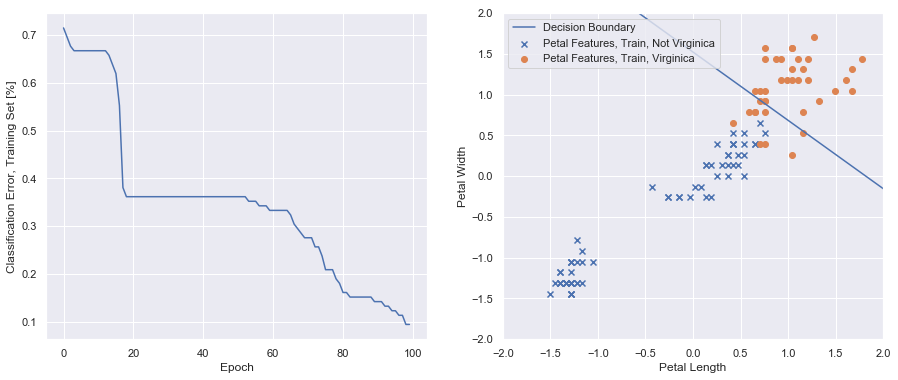

In [82]:
# accuracy curve, in terms of classification error percentage
plt.figure(1, figsize=(15,6))
plt.subplot(121)
plt.plot(np.array(py_acc) / len(y_train_2))
plt.xlabel('Epoch')
plt.ylabel('Classification Error, Training Set [%]')

def sigmoid(x):
    return 1 / (1 + np.exp(-x))
# compute test error
pred = np.round(sigmoid(x_test_2 @ py_w + py_b))
error = np.sum(pred - np.squeeze(y_test_2)) / y_test_2.shape[0]

print('Test Error is: \t' + str(error * 100))

# decision boundary
plt.subplot(122)
x2 = np.linspace(-2, 2, 20) # petal length
x1 = (-1 / py_w[0]) * (py_b + x2 * py_w[1])
plt.plot(x1, x2, label='Decision Boundary')
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
# class idx
idx_1 = np.where(np.squeeze(y_train_2) == 0)[0]
idx_2 = np.where(np.squeeze(y_train_2) == 1)[0]
plt.scatter(x_train_2.petal_length.iloc[idx_1], x_train_2.petal_width.iloc[idx_1], label='Petal Features, Train, Not Virginica', marker='x')
plt.scatter(x_train_2.petal_length.iloc[idx_2], x_train_2.petal_width.iloc[idx_2], label='Petal Features, Train, Virginica')
#plt.scatter(x_test_2.petal_length, x_test_2.petal_width, label='Petal_Features, Test')
# here I need to plot the type of flower as scatter style... this way to see seperability
plt.legend(loc='upper left')
plt.xlim(-2, 2)
plt.ylim(-2,2)

### Explanation
Its clear from above plots that virginica vs non virginica is a more difficult case - since the data, at least when only using the two features petal length and petal width, is not really linearly separable for this case. Examination of setosa vs non-setosa (the first set of plots) shows a very clear cluster that is more easily linearly separable.

<h1>Part c:</h1>

In [83]:
x_3,y_3 = data_preprocessing(dataset,4)
#generate traning and validation sets
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(x_3,y_3,test_size=0.3)

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], dtype='object')
species


<h2>Define hyper-parameters</h2>

In [133]:
num_epochs = 1000
lr = 0.01

<h2>Define placehoder and variables</h2>

In [134]:
tf.reset_default_graph()

x_in = tf.placeholder(tf.float32, shape=[None, 4]) # input data
y_hat = tf.placeholder(tf.float32, shape=[None, 3]) # output classification, one-hot

n1, n2 = 256, 128 # neurons in each layer

# weights and biases
# api suggests using get_variable, will try here, should work same except for different initialization
w1 = tf.get_variable('weight1', [4, n1])
b1 = tf.get_variable('bias1', [1,1])
w2 = tf.get_variable('weight2', [n1, n2])
b2 = tf.get_variable('bias2', [1,1])
w_out = tf.get_variable('weight_out', [n2, 3])
b_out = tf.get_variable('b_out', [1,1])

<h2>Define the neural network</h2>

In [135]:
# first layer
n1_out = tf.nn.relu(tf.add(tf.matmul(x_in, w1), b1))
# second layer
n2_out = tf.nn.relu(tf.add(tf.matmul(n1_out, w2), b2))
# output layer, leave softmax to tensorflow 
out = tf.add(tf.matmul(n2_out, w_out), b_out)

<h2>Define cost function and accuracy</h2>

In [136]:
# cost function
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_hat, logits=out))
# optimize with standard gradient
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
train_op = optimizer.minimize(cost)

# compare the predicted labels with true labels
correct_pred = tf.equal(tf.argmax(out,1),tf.argmax(y_hat,1))

# compute the accuracy by taking average
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32),name='accuracy')


<h2>Execute training</h2>

In [163]:
# D. Cashon
# Success depends somewhat on initialization. If poor, run again. (Observe stuck at 0.38)
init = tf.global_variables_initializer()
acc_holder = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_epochs):
        # train
        sess.run(train_op, feed_dict={x_in: x_train_3, y_hat: y_train_3})
        acc = sess.run(accuracy, feed_dict={x_in: x_train_3, y_hat: y_train_3})
        acc_holder.append(acc) # slower to compute accuracy each time, but OK 
        if i % 100 == 0:
            # print accuracy
            print('Accuracy: ')
            print(acc)
            #print('Cost: ')
            #print(sess.run(cost, feed_dict={x_in: x_train_3, y_hat: y_train_3}))
    # test accuracy
    print('Test Data Accuracy:' )
    print(sess.run(accuracy, feed_dict={x_in: x_test_3, y_hat: y_test_3}))

Accuracy: 
0.3809524
Accuracy: 
0.9142857
Accuracy: 
0.95238096
Accuracy: 
0.96190476
Accuracy: 
0.96190476
Accuracy: 
0.96190476
Accuracy: 
0.96190476
Accuracy: 
0.96190476
Accuracy: 
0.96190476
Accuracy: 
0.9714286
Test Data Accuracy:
0.9777778


<h2>Plot</h2>

Accuracy vs Epochs Plot below

Text(0, 0.5, 'Classification Accuracy')

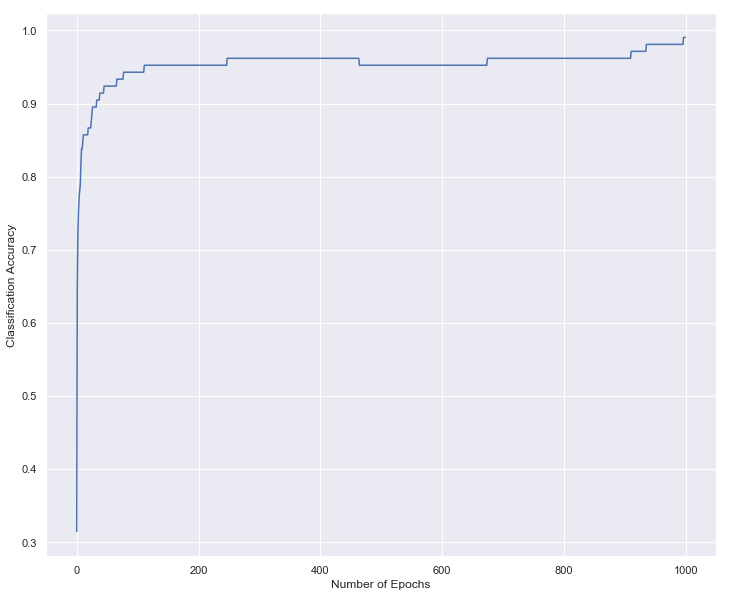

In [156]:
plt.figure(1, figsize=(12,10))
plt.plot(np.arange(len(acc_holder)), acc_holder)
plt.xlabel('Number of Epochs')
plt.ylabel('Classification Accuracy')